In [17]:
import numpy as np
import pickle
import random
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [18]:
# ====================================================
# PART 1: Hangman Environment (w/ Tuned Rewards)
# ====================================================

class HangmanEnv:
    def __init__(self, word_list, max_wrong=6):
        self.all_words = word_list
        self.word_list = word_list # This will be updated by the curriculum
        self.max_wrong = max_wrong

        # --- Rewards based on your friend's successful model ---
        self.reward_win = 100.0         # Large win bonus
        self.reward_loss = -100.0       # Large loss penalty
        self.reward_correct = 5.0       # Positive reward for correct guess
        self.reward_wrong = -20.0       # Strong penalty for wrong guess
        self.reward_repeated = -30.0    # Very strong penalty for repeated guess

        self.reset()

    def reset(self, word=None):
        self.target = (word or random.choice(self.word_list)).upper()
        self.masked = "_" * len(self.target)
        self.guessed = set()
        self.wrong = 0
        self.done = False
        self.won = False
        return self.get_state()

    def get_state(self):
        # This is our Q-table key: (masked_word, sorted_guessed_string)
        return (self.masked, "".join(sorted(list(self.guessed))))

    def step(self, letter):
        letter = letter.upper()

        if letter in self.guessed:
            return self.get_state(), self.reward_repeated, False, {"info": "Repeated guess"}

        self.guessed.add(letter)

        if letter in self.target:
            new_masked_list = list(self.masked)
            for i, c in enumerate(self.target):
                if c == letter:
                    new_masked_list[i] = letter
            self.masked = "".join(new_masked_list)

            if "_" not in self.masked:
                self.done = True
                self.won = True
                return self.get_state(), self.reward_win, True, {"info": "Game won"}
            else:
                return self.get_state(), self.reward_correct, False, {"info": "Correct guess"}
        else:
            self.wrong += 1
            if self.wrong >= self.max_wrong:
                self.done = True
                return self.get_state(), self.reward_loss, True, {"info": "Game lost"}
            else:
                return self.get_state(), self.reward_wrong, False, {"info": "Wrong guess"}



In [19]:
# ====================================================
# PART 2: HMM Oracle (Same as before, it's perfect)
# ====================================================

class HMMOracle:
    def __init__(self, corpus_path="corpus.txt"):
        print("Initializing HMM Oracle...")
        self.corpus_path = corpus_path
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.num_states = len(self.alphabet)
        self.char_to_int = {char: i for i, char in enumerate(self.alphabet)}
        self.int_to_char = {i: char for i, char in enumerate(self.alphabet)}
        self.full_word_list = self.load_words(self.corpus_path)
        print(f"Loaded {len(self.full_word_list)} words for filtering.")
        self.start_probs, self.transition_probs = self.train_or_load_hmm_matrices()
        print("HMM probability matrices are ready.")

    def load_words(self, path):
        with open(path, 'r') as f:
            words = [
                line.strip().upper()
                for line in f
                if line.strip().isalpha() and len(line.strip()) > 0
            ]
        return words

    def train_or_load_hmm_matrices(self, start_prob_file="hmm_start.npy", trans_prob_file="hmm_trans.npy"):
        try:
            if os.path.exists(start_prob_file) and os.path.exists(trans_prob_file):
                start_probs = np.load(start_prob_file)
                trans_probs = np.load(trans_prob_file)
                print(f"Loading HMM matrices from {start_prob_file} and {trans_prob_file}...")
                return start_probs, trans_probs
            else:
                raise FileNotFoundError
        except (FileNotFoundError, IOError):
            print("No HMM matrices found. Calculating from corpus...")
            start_counts = np.ones(self.num_states)
            for word in self.full_word_list:
                start_counts[self.char_to_int[word[0]]] += 1
            start_probs = start_counts / start_counts.sum()
            trans_counts = np.ones((self.num_states, self.num_states))
            for word in self.full_word_list:
                for i in range(len(word) - 1):
                    char1 = self.char_to_int[word[i]]
                    char2 = self.char_to_int[word[i+1]]
                    trans_counts[char1, char2] += 1
            row_sums = trans_counts.sum(axis=1)
            trans_probs = trans_counts / row_sums[:, np.newaxis]
            np.save(start_prob_file, start_probs)
            np.save(trans_prob_file, trans_probs)
            print("HMM matrices calculated and saved.")
        return start_probs, trans_probs

    def get_letter_probabilities(self, masked_word, guessed_letters):
        possible_words = []
        for word in self.full_word_list:
            if self.is_word_possible(word, masked_word, guessed_letters):
                possible_words.append(word)

        freq_probs = np.zeros(self.num_states)
        if possible_words:
            total_valid_letters = 0
            for word in possible_words:
                unique_chars_in_word = set(word) - guessed_letters
                for char in unique_chars_in_word:
                    freq_probs[self.char_to_int[char]] += 1
                    total_valid_letters += 1
            if total_valid_letters > 0:
                freq_probs = freq_probs / total_valid_letters

        hmm_probs = np.zeros(self.num_states)
        blanks_counted = 0
        for i, char in enumerate(masked_word):
            if char == '_':
                blanks_counted += 1
                prev_char = None
                for j in range(i - 1, -1, -1):
                    if masked_word[j] != '_':
                        prev_char = masked_word[j]
                        break
                if prev_char:
                    prev_state_index = self.char_to_int[prev_char]
                    hmm_probs += self.transition_probs[prev_state_index, :]
                else:
                    hmm_probs += self.start_probs
        if blanks_counted > 0 and hmm_probs.sum() > 0:
            hmm_probs = hmm_probs / hmm_probs.sum()

        final_probs = (0.8 * freq_probs) + (0.2 * hmm_probs)

        for char in guessed_letters:
            if char in self.char_to_int:
                final_probs[self.char_to_int[char]] = 0

        total_prob = final_probs.sum()
        if total_prob > 0:
            final_probs = final_probs / total_prob
        else:
            for char_int in range(self.num_states):
                if self.int_to_char[char_int] not in guessed_letters:
                    final_probs[char_int] = 1.0
            total_prob = final_probs.sum()
            if total_prob > 0:
                final_probs = final_probs / total_prob
        return final_probs

    def is_word_possible(self, word, masked_word, guessed_letters):
        if len(word) != len(masked_word):
            return False
        correct_guesses = set(c for c in masked_word if c != '_')
        for i, (word_char, mask_char) in enumerate(zip(word, masked_word)):
            if mask_char != '_' and word_char != mask_char:
                return False
            if mask_char == '_' and word_char in correct_guesses:
                return False
        wrong_guesses = guessed_letters - correct_guesses
        for char in wrong_guesses:
            if char in word:
                return False
        return True



In [20]:
class QLearningAgent:
    def __init__(self, oracle, alpha=0.1, gamma=0.9, hmm_weight=20.0):
        self.oracle = oracle
        self.q = defaultdict(lambda: defaultdict(float)) # Our Q-table
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.hmm_weight = hmm_weight # How much to trust the HMM
        self.alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

        # Epsilon (exploration) settings
        self.epsilon = 0.9  # Start high
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995 # Decay per step

    def get_valid_actions(self, guessed_set):
        return [c for c in self.alphabet if c not in guessed_set]

    def choose_action(self, state, guessed_set, train=True):
        valid_actions = self.get_valid_actions(guessed_set)
        if not valid_actions:
            return 'A' # Failsafe

        # --- Epsilon-Greedy ---
        if train and random.random() < self.epsilon:
            # Exploration: Use HMM to make a "smart" random guess
            probs_vec = self.oracle.get_letter_probabilities(state[0], guessed_set)
            probs = {self.alphabet[i]: p for i, p in enumerate(probs_vec) if self.alphabet[i] in valid_actions}
            if not probs or sum(probs.values()) == 0:
                return random.choice(valid_actions) # Fallback to pure random

            # Choose from HMM probabilities
            letters = list(probs.keys())
            probabilities = list(probs.values())
            return np.random.choice(letters, p=probabilities)

        # --- Exploitation ---
        # Get Q-values, boosted by HMM probabilities
        q_values = {}
        hmm_probs = self.oracle.get_letter_probabilities(state[0], guessed_set)

        for action in valid_actions:
            q_val = self.q[state][action] # 0.0 if not seen
            hmm_boost = hmm_probs[self.oracle.char_to_int[action]]
            q_values[action] = q_val + (self.hmm_weight * hmm_boost)

        if not q_values:
            return random.choice(valid_actions)

        return max(q_values, key=q_values.get)

    def update(self, state, action, reward, next_state, done):
        # --- Standard Q-learning equation ---
        old_q = self.q[state][action]

        # Find the max Q-value for the next state
        next_q_values = self.q[next_state]
        max_next_q = max(next_q_values.values()) if next_q_values else 0.0

        # Bellman equation
        if done:
            target = reward
        else:
            target = reward + self.gamma * max_next_q

        # Update the Q-value
        self.q[state][action] = old_q + self.alpha * (target - old_q)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


--- FINAL SPRINT: Q-LEARNING + CURRICULUM ---
Loading all words for curriculum...
Loaded 49979 train words, 2000 test words.
Initializing HMM Oracle...
Loaded 49979 words for filtering.
No HMM matrices found. Calculating from corpus...
HMM matrices calculated and saved.
HMM probability matrices are ready.

--- Starting Curriculum Training (Total 10000 Episodes) ---

--- STAGE: Short Words (3-5) (3897 words, 2000 episodes) ---


100%|██████████| 2000/2000 [02:01<00:00, 16.52it/s]


Stage Done. Avg Reward: -18.70, Avg Wrong: 3.52

--- STAGE: Medium Words (6-8) (15214 words, 4000 episodes) ---


100%|██████████| 4000/4000 [07:50<00:00,  8.50it/s]


Stage Done. Avg Reward: 78.10, Avg Wrong: 2.08

--- STAGE: Long Words (9+) (30738 words, 4000 episodes) ---


100%|██████████| 4000/4000 [08:42<00:00,  7.66it/s]


Stage Done. Avg Reward: 115.35, Avg Wrong: 1.09

--- Training Complete. Total Time: 1114.43s ---
Plotting results...


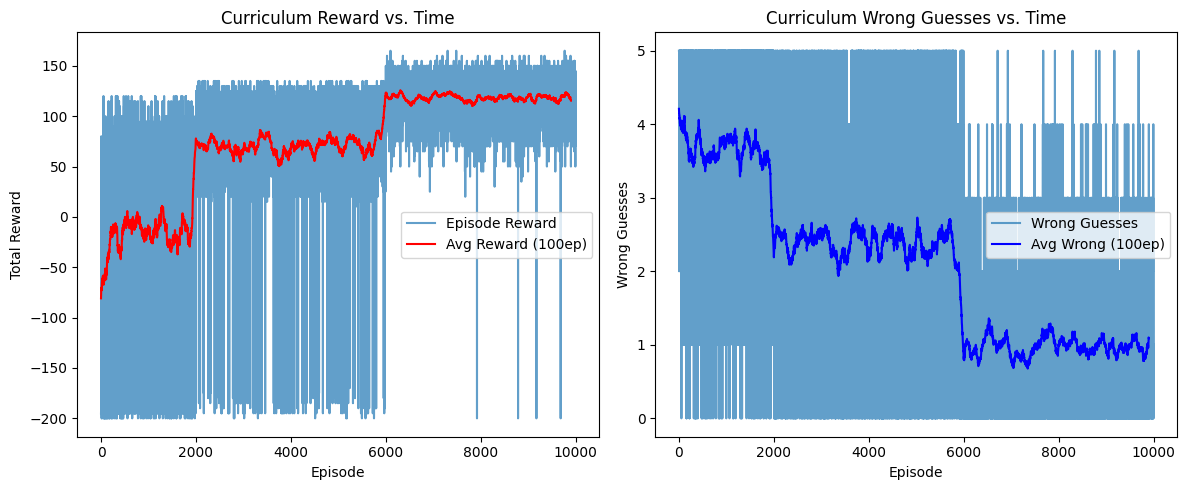


--- Running 2000 Game Evaluation on test.txt ---


100%|██████████| 2000/2000 [04:46<00:00,  6.98it/s]


--- Evaluation Complete ---

--- 📊 Final Hackathon Report ---
--------------------------------------
Total Games Played:   2000
Total Wins:             512 (25.60%)
Total Wrong Guesses:    9403
Total Repeated Guesses: 0
--------------------------------------
Success Rate Score:     + 512.00
Wrong Guess Penalty:    - 47015
Repeated Guess Penalty: - 0
--------------------------------------
🏆 FINAL SCORE: -46503.00
--------------------------------------

--- Averages for Analysis_Report.pdf ---
Avg. Wrong Guesses per game:    4.70
Avg. Repeated Guesses per game: 0.00


In [21]:
# ====================================================
# PART 4 & 5: Training + Evaluation Loop
# ====================================================

print("--- FINAL SPRINT: Q-LEARNING + CURRICULUM ---")
start_time = time.time()

# --- 1. Load Data ---
print("Loading all words for curriculum...")
with open("corpus.txt", 'r') as f:
    all_words = [
        line.strip().upper()
        for line in f
        if line.strip().isalpha() and len(line.strip()) > 0
    ]

with open("test.txt", 'r') as f:
    test_words = [
        line.strip().upper()
        for line in f
        if line.strip().isalpha() and len(line.strip()) > 0
    ]
print(f"Loaded {len(all_words)} train words, {len(test_words)} test words.")

# --- 2. Initialize Components ---
oracle = HMMOracle(corpus_path="corpus.txt")
agent = QLearningAgent(oracle=oracle)
env = HangmanEnv(word_list=all_words)

# --- 3. Define Curriculum ---
# Reduced episodes for speed
curriculum_stages = [
    {"name": "Short Words (3-5)", "words": [w for w in all_words if 3 <= len(w) <= 5], "episodes": 2000},
    {"name": "Medium Words (6-8)", "words": [w for w in all_words if 6 <= len(w) <= 8], "episodes": 4000},
    {"name": "Long Words (9+)", "words": [w for w in all_words if len(w) >= 9], "episodes": 4000}
]
full_reward_history = []
full_wrong_guess_history = []

# --- 4. Run Training ---
print(f"\n--- Starting Curriculum Training (Total {sum(s['episodes'] for s in curriculum_stages)} Episodes) ---")
for stage in curriculum_stages:
    print(f"\n--- STAGE: {stage['name']} ({len(stage['words'])} words, {stage['episodes']} episodes) ---")
    if not stage['words']:
        print("No words, skipping stage.")
        continue

    env.word_list = stage['words'] # Set the env to use only this stage's words
    rewards_deque = deque(maxlen=100)
    wrong_guesses_deque = deque(maxlen=100)

    for i_episode in tqdm(range(stage['episodes'])):
        state = env.reset()
        current_wrong_guesses = 0
        current_reward = 0

        done = False
        while not done:
            action = agent.choose_action(state, env.guessed, train=True)
            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state, done)

            state = next_state
            current_reward += reward
            if reward == env.reward_wrong:
                current_wrong_guesses += 1

        full_reward_history.append(current_reward)
        full_wrong_guess_history.append(current_wrong_guesses)
        rewards_deque.append(current_reward)
        wrong_guesses_deque.append(current_wrong_guesses)

    print(f"Stage Done. Avg Reward: {np.mean(rewards_deque):.2f}, Avg Wrong: {np.mean(wrong_guesses_deque):.2f}")

print(f"\n--- Training Complete. Total Time: {time.time() - start_time:.2f}s ---")

# --- 5. Plot Results ---
print("Plotting results...")
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(full_reward_history, label='Episode Reward', alpha=0.7)
plt.plot(moving_average(full_reward_history, 100), label='Avg Reward (100ep)', color='red')
plt.title('Curriculum Reward vs. Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(full_wrong_guess_history, label='Wrong Guesses', alpha=0.7)
plt.plot(moving_average(full_wrong_guess_history, 100), label='Avg Wrong (100ep)', color='blue')
plt.title('Curriculum Wrong Guesses vs. Time')
plt.xlabel('Episode')
plt.ylabel('Wrong Guesses')
plt.legend()
plt.tight_layout()
plt.show()

# --- 6. Run Final Evaluation ---
print(f"\n--- Running 2000 Game Evaluation on test.txt ---")
NUM_EVAL_GAMES = 2000
total_wins = 0
total_wrong_guesses = 0
total_repeated_guesses = 0

# Set the env to use the test words
eval_env = HangmanEnv(word_list=test_words)
# We must use the test.txt for evaluation, up to 2000 games
words_to_evaluate = test_words[:NUM_EVAL_GAMES]

for word in tqdm(words_to_evaluate):
    state = eval_env.reset(word=word) # Reset to a specific word

    done = False
    while not done:
        # IMPORTANT: Set train=False for no exploration
        action = agent.choose_action(state, eval_env.guessed, train=False)
        next_state, reward, done, info = eval_env.step(action)

        if info['info'] == "Wrong guess":
            total_wrong_guesses += 1
        elif info['info'] == "Repeated guess":
            total_repeated_guesses += 1

        if done and info['info'] == "Game won":
            total_wins += 1

        state = next_state

# --- 7. Print Final Report ---
print("\n--- Evaluation Complete ---")

success_rate = total_wins / len(words_to_evaluate)
avg_wrong_guesses = total_wrong_guesses / len(words_to_evaluate)
avg_repeated_guesses = total_repeated_guesses / len(words_to_evaluate)

score_from_wins = success_rate * 2000
penalty_wrong = total_wrong_guesses * 5
penalty_repeated = total_repeated_guesses * 2
final_score = score_from_wins - penalty_wrong - penalty_repeated

print("\n--- 📊 Final Hackathon Report ---")
print("--------------------------------------")
print(f"Total Games Played:   {len(words_to_evaluate)}")
print(f"Total Wins:             {total_wins} ({success_rate * 100:.2f}%)")
print(f"Total Wrong Guesses:    {total_wrong_guesses}")
print(f"Total Repeated Guesses: {total_repeated_guesses}")
print("--------------------------------------")
print(f"Success Rate Score:     + {score_from_wins:.2f}")
print(f"Wrong Guess Penalty:    - {penalty_wrong}")
print(f"Repeated Guess Penalty: - {penalty_repeated}")
print("--------------------------------------")
print(f"🏆 FINAL SCORE: {final_score:.2f}")
print("--------------------------------------")
print("\n--- Averages for Analysis_Report.pdf ---")
print(f"Avg. Wrong Guesses per game:    {avg_wrong_guesses:.2f}")
print(f"Avg. Repeated Guesses per game: {avg_repeated_guesses:.2f}")